We use the uniform distribution for analytical find the conditionary expectation of profit

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.stats import chisquare
import scipy.optimize 

C:\Users\user\AppData\Local\Temp\ipykernel_3660\4031924887.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def expectedProfit_montecarlo(distr, params, C, f, S, sigma2, n = 20000):
    answ = 0
    for i in range(n):
        cc = np.abs(distr(*params))
        answ -= f
        if cc>= sigma2:
            answ += S * 1/8*(sigma2-cc)**2
    return answ/n

In [3]:
C = np.random.uniform(1,2, size = 100)
expectedProfit_montecarlo(np.random.uniform, (1,2), C, 0.01, 1, 1.5)

-0.004709299973695426

In [4]:
a = 1
b = 2

C = np.random.uniform(a,b, size = 10000)
C2 = [x*x for x in C]
print(np.mean(C2))
print(1/3 * (b-a)**2 + a*(b-a) + a**2)

sigma2 = 1.5
print((1/3*(b-sigma2)**2 + sigma2*(b-sigma2) + sigma2**2)*0.5)

answ = 0
for x in C:
    if x >= sigma2:
        answ += x**2
print(answ/10000)

2.3317051927749177
2.333333333333333
1.5416666666666667
1.541086053424494


In [5]:
f = 0.01

P = 1/8*(sigma2**2 - sigma2 * (sigma2+b) +  (1/3*(b-sigma2)**2 + sigma2*(b-sigma2) + sigma2**2))*(b-sigma2)/(b-a)-f
print(P)

-0.004791666666666658


In [192]:
class ApsundNokeModel():
    def __init__(self, distr, data, n_depth = 20000):
        self.distr = distr
        self.setData(data)
        self.n_depth = n_depth
    
    def setData(self, data):
        self.data = data
        self.n_epochs = data.shape[0]
        self.k_params = 0
        for x in self.data.columns:
            if x[0:5] == "param":
                self.k_params+=1

    def getParams(self, epoch):
        params = (self.data[f"param_0"][epoch],)
        for i in range(1, self.k_params):
            params += (self.data[f"param_{i}"][epoch],)
        return params
        
    
    def Sigma2(self, C, epoch):
        sigma = self.data["sigma"][epoch]
        return (2+sigma*np.sum(C))/(2+sigma*len(C))
    
    def expectedProfit_montecarlo(self, C, epoch):
        f = self.data["f"][epoch]
        S = self.data["S"][epoch]
        params = self.getParams(epoch)
        n = self.n_depth
        sigma2 = self.Sigma2(C, epoch)
        if self.distr == np.random.uniform:
            a, b = params[0], params[1]
            if sigma2 > b:
                return S*0.125*(sigma2**2-sigma2*(b+a)+1/3*(b**2+b*a+a**2))-f
            if sigma2 < a:
                return -f
            return S * 1/24*(sigma2-a)**3/(b-a)-f

        answ = 0
        for i in range(n):
            cc = np.abs(self.distr(*params))
            answ -= f
            if cc<= sigma2:
                answ += S * 1/8*(sigma2-cc)**2
        return answ/n

    def NPV_for_entrant(self, C, epoch):
        r = self.data["r"][epoch]
        return ((1+r)/r) * self.expectedProfit_montecarlo(C, epoch)
    
    def scenario(self, out = False):
        #data prepare
        NPV_ent = [0] * self.n_epochs
        M = [0] * self.n_epochs
        P_mean = [0] * self.n_epochs
        EP_ = [0] * self.n_epochs
        C_mean = [0] * self.n_epochs
        C_min = [0] * self.n_epochs
        C_max = [0] * self.n_epochs
        Sigma2 = [0] * self.n_epochs
        M_ent = [0] * self.n_epochs
        M_ex = [0] * self.n_epochs
        M2 = [0] * self.n_epochs

        #zero epoch
        params = self.getParams(0)
        C = np.abs(self.distr(*params, size = 1))
        
        for epoch in range(self.n_epochs):
            #loading data
            params = self.getParams(epoch)
            f = self.data["f"][epoch]
            r = self.data["r"][epoch]
            ef = self.data["ef"][epoch]
            alpha = self.data["alpha"][epoch]
            S = self.data["S"][epoch]

            NPV1 = self.NPV_for_entrant(C, epoch)
            EP = self.expectedProfit_montecarlo(C, epoch)

            #entrance stage
            n_ent = 0
            while NPV1 > ef:
                c = np.abs(self.distr(*params, size = 1))
                C = np.append(C, c)
                n_ent += 1
                NPV1 = self.NPV_for_entrant(C, epoch)
            
            M[epoch] = len(C)    
            
            # sort of C
            C = np.flip(np.sort(C))

            # exit stage
            EP = self.expectedProfit_montecarlo(C, epoch)
            sigma2 = self.Sigma2(C, epoch)
            n_ex = 0
            i = 0
            P_fact = []
            while (i < len(C)):
                P = - f
                if sigma2 > C[i]:
                    P = S * 1/8*(sigma2 - C[i])**2 - f
                P_fact.append(P)
                NPV2 = (1+r)/(1+r-alpha) * P + (1/r - alpha/(1+r-alpha))*EP
                if NPV2 < 0:
                    C = np.delete(C, i)
                    n_ex += 1
                    EP = self.expectedProfit_montecarlo(C, epoch)
                    sigma2 = self.Sigma2(C, epoch)
                else:
                    i += 1                    
                                    
            
            #recounting stage
            for i in range(len(C)):
                a = random.random()
                if a > alpha:
                    C[i] = np.abs(self.distr(*params))
            
            # sort of C
            #C = np.flip(np.sort(C))
                    
            M2[epoch] = len(C)
            NPV_ent[epoch] = NPV1
            P_mean[epoch] = np.mean(P_fact)
            EP_[epoch] = EP
            C_mean[epoch] = np.mean(C)
            C_min[epoch] = np.min(C)
            C_max[epoch] = np.max(C)
            Sigma2[epoch] = sigma2
            M_ent[epoch] = n_ent
            M_ex[epoch] = n_ex

            if out:
                print(f"epoch{epoch}, number of firms: {M[epoch]}, entrats: {M_ent[epoch]}, exiters: {M_ex[epoch]}, EP: {EP_[epoch]}, C_mean: {C_mean[epoch]}, EP_fact: {P_mean[epoch]}")
        
        self.data["NPV_ent"] = NPV_ent
        self.data["n_firms"] = M
        self.data["n_firms_2"] = M2
        self.data["Pr_mean"] = P_mean
        self.data["EP"] = EP_
        self.data["C_mean"] = C_mean
        self.data["C_min"] = C_min
        self.data["C_max"] = C_max
        self.data["Sigma2"] = Sigma2
        self.data["n_entr"] = M_ent
        self.data["n_ext"] = M_ex

    def getData(self):
        return self.data

In [193]:
#parameters of distribution
Ec = 2
Dc = 0.04
scale = Dc**0.5

#parameters of utility
sigma = 0.5
S = 4

#parameters of firms
f = 0.001 # fixed costs
ef = 0.01 # entrance costs
r = 0.02 #return of interest
alpha = 0.8
a=0.6
b=0.8

n = 10000

data = {"param_0": [a]*n,
        "param_1": [b]*n,
        "sigma": [sigma]*n,
        "S": [S]*n,
        "f": [f]*n,
        "ef": [ef]*n,
        "r": [r]*n,
        "alpha": [alpha]*n}

df = pd.DataFrame(data)
df

,param_0,param_1,sigma,S,f,ef,r,alpha
0,0.6,0.8,0.5,4,0.001,0.01,0.02,0.8
1,0.6,0.8,0.5,4,0.001,0.01,0.02,0.8
2,0.6,0.8,0.5,4,0.001,0.01,0.02,0.8
3,0.6,0.8,0.5,4,0.001,0.01,0.02,0.8
4,0.6,0.8,0.5,4,0.001,0.01,0.02,0.8
...,...,...,...,...,...,...,...,...
9995,0.6,0.8,0.5,4,0.001,0.01,0.02,0.8
9996,0.6,0.8,0.5,4,0.001,0.01,0.02,0.8
9997,0.6,0.8,0.5,4,0.001,0.01,0.02,0.8
9998,0.6,0.8,0.5,4,0.001,0.01,0.02,0.8


In [194]:
Noke = ApsundNokeModel(distr = np.random.uniform,
                       data = df)

In [195]:
Noke.scenario(out=True)

epoch0, number of firms: 59, entrats: 58, exiters: 0, EP: 0.00019256478626540228, C_mean: 0.6938277562806534, EP_fact: 0.00041748761118727497
epoch1, number of firms: 69, entrats: 10, exiters: 0, EP: 0.00017366576405208022, C_mean: 0.6983672123420444, EP_fact: 0.00031349869402485023
epoch2, number of firms: 89, entrats: 20, exiters: 0, EP: 0.00018748468235327016, C_mean: 0.7007947123471656, EP_fact: 0.00017111562450531544
epoch3, number of firms: 93, entrats: 4, exiters: 0, EP: 0.00018589536309920342, C_mean: 0.6989816637186075, EP_fact: 7.312131937196389e-05
epoch4, number of firms: 93, entrats: 0, exiters: 0, EP: 0.00015189635181182067, C_mean: 0.6984061471027008, EP_fact: 9.55544037801986e-05
epoch5, number of firms: 93, entrats: 0, exiters: 0, EP: 0.00013486355987177377, C_mean: 0.6988879859277647, EP_fact: 0.00012760063619219193
epoch6, number of firms: 93, entrats: 0, exiters: 0, EP: 0.00014911236341009658, C_mean: 0.6962254444068801, EP_fact: 0.000143918206203832
epoch7, number 

In [196]:
result = Noke.getData()
result

,param_0,param_1,sigma,S,f,ef,r,alpha,NPV_ent,n_firms,n_firms_2,Pr_mean,EP,C_mean,C_min,C_max,Sigma2,n_entr,n_ext
0,0.6,0.8,0.5,4,0.001,0.01,0.02,0.8,0.009821,59,59,0.000417,0.000193,0.693828,0.603624,0.798118,0.712691,58,0
1,0.6,0.8,0.5,4,0.001,0.01,0.02,0.8,0.008857,69,69,0.000313,0.000174,0.698367,0.601941,0.798118,0.712092,10,0
2,0.6,0.8,0.5,4,0.001,0.01,0.02,0.8,0.009562,89,89,0.000171,0.000187,0.700795,0.603624,0.798118,0.712530,20,0
3,0.6,0.8,0.5,4,0.001,0.01,0.02,0.8,0.009481,93,93,0.000073,0.000186,0.698982,0.603624,0.798118,0.712480,4,0
4,0.6,0.8,0.5,4,0.001,0.01,0.02,0.8,0.007747,93,93,0.000096,0.000152,0.698406,0.603624,0.799903,0.711395,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.6,0.8,0.5,4,0.001,0.01,0.02,0.8,0.009506,21,21,0.001970,0.000186,0.662427,0.602607,0.786272,0.712496,8,0
9996,0.6,0.8,0.5,4,0.001,0.01,0.02,0.8,0.005198,25,25,0.001560,0.000102,0.665413,0.602607,0.786272,0.709760,4,0
9997,0.6,0.8,0.5,4,0.001,0.01,0.02,0.8,0.008013,25,25,0.001529,0.000157,0.672582,0.602607,0.786272,0.711563,0,0
9998,0.6,0.8,0.5,4,0.001,0.01,0.02,0.8,0.009974,28,28,0.001356,0.000196,0.668170,0.602607,0.786272,0.712785,3,0


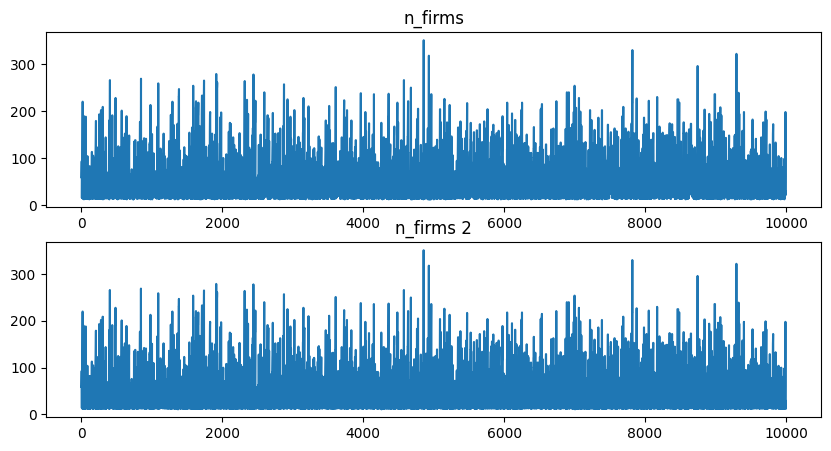

In [197]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.title('n_firms')
plt.plot(result["n_firms"])
plt.subplot(2,1,2)
plt.title('n_firms 2')
plt.plot(result["n_firms_2"])

In [225]:
m=result["n_firms"][1:].mean()
m2=result["n_firms_2"][1:].mean()
sigma_est=result["Sigma2"][1:].mean()
c_max=result["C_max"][1:].mean()
sigma_est,m, c_max

(0.7100416561022989, 67.87578757875788, 0.7793515029985862)

In [294]:
mm = (2-2*f**0.5 - 2*c_max)/(sigma*(c_max-a+f**0.5))
mm

3.5838628435252735

In [213]:
count = 0
ssss = 0
for i in result["n_firms"]:
        if i < 13:
                count += 1
                ssss += i
print(count)

74


In [275]:
#x0 - sigma2
#x1 - m
#x2 - c^

ef_added = 0

def fun(x):
    
    global sigma,S,f,ef,r,alpha,a,b, ef_added

    y = [x[0]-(2+sigma*x[1]/2 * (x[2]+a))/(2+sigma*x[1]),
         (1+r)/r*(S/24*(x[0]-a)**3/(b-a)-f)-ef-ef_added,
         (1+r)/(1+r-alpha)*(S/8*(x[0]-x[2])**2-f)+1/r*(S/24*(x[0]-a)**3/(b-a)-f)-(alpha)/(1+r-alpha)*(S/24*(x[0]-a)**3/(b-a)-f)]
    return y

In [291]:
x0 = scipy.optimize.fsolve(fun,[sigma_est,m,c_max], maxfev=1000)
x0,fun(x0), fun([sigma_est, m, c_max])

C:\Users\user\AppData\Local\Temp\ipykernel_3660\142247109.py:1: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  x0 = scipy.optimize.fsolve(fun,[sigma_est,m,c_max], maxfev=1000)


(array([7.71823994e-01, 1.51290833e+03, 8.16867372e-01]),
 [0.06262146414724012, -0.14440416926440777, 0.14969958259498528],
 [0.003095874794390885, -0.30336821070849357, 0.01161965384301158])

In [286]:
M = []

for i in np.arange(0, 0.3, 0.001):
    ef_added = i
    x0 = scipy.optimize.fsolve(fun,[sigma_est,m,c_max], maxfev=1000)
    M.append((ef_added, x0[1]))
M

C:\Users\user\AppData\Local\Temp\ipykernel_3660\3557257179.py:5: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  x0 = scipy.optimize.fsolve(fun,[sigma_est,m,c_max], maxfev=1000)
C:\Users\user\AppData\Local\Temp\ipykernel_3660\3557257179.py:5: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  x0 = scipy.optimize.fsolve(fun,[sigma_est,m,c_max], maxfev=1000)


[(0.0, 20.720125624142906),
 (0.001, 20.651400225093433),
 (0.002, 20.55089182231412),
 (0.003, 20.480593570763435),
 (0.004, 20.36824600223363),
 (0.005, 20.276533047755986),
 (0.006, 20.20115331670527),
 (0.007, 20.11446963556385),
 (0.008, 19.986362919942337),
 (0.009000000000000001, 19.965846886096895),
 (0.01, 19.870086141225137),
 (0.011, 19.77864234792252),
 (0.012, 19.71858411227527),
 (0.013000000000000001, 19.641374818966717),
 (0.014, 19.561556684074),
 (0.015, 19.469913213934518),
 (0.016, 19.43409781392125),
 (0.017, 19.34259481430185),
 (0.018000000000000002, 67.87578757875788),
 (0.019, 19.188472911758407),
 (0.02, 19.12966186204661),
 (0.021, 19.05432820480034),
 (0.022, 19.00619771589026),
 (0.023, 18.936588289876426),
 (0.024, 18.84494008047322),
 (0.025, 18.792443788858584),
 (0.026000000000000002, 18.71531584306292),
 (0.027, 18.579386950542624),
 (0.028, 18.593102939165494),
 (0.029, 18.509831366328456),
 (0.03, 18.41710881408083),
 (0.031, 18.40646667238817),
 (0.

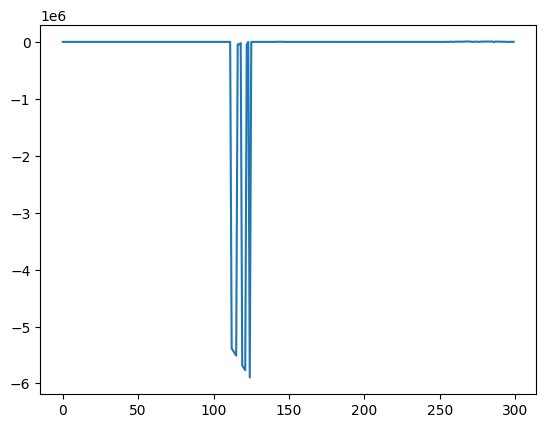

In [274]:
plt.plot(M)